# Support vector machine example from cvxpy examples

In [1]:
import numpy as np

np.random.seed(1)
n = 20
m = 1000
TEST = m
DENSITY = 0.2
beta_true = np.random.randn(n,1)
idxs = np.random.choice(range(n), int((1-DENSITY)*n), replace=False)
for idx in idxs:
    beta_true[idx] = 0
offset = 0

sigma = 45
X = np.random.normal(0, 5, size=(m,n))
Y = np.sign(X.dot(beta_true) + offset + np.random.normal(0,sigma,size=(m,1)))
X_test = np.random.normal(0, 5, size=(TEST,n))
Y_test = np.sign(X_test.dot(beta_true) + offset + np.random.normal(0,sigma,size=(TEST,1)))

## solving the problem with cvxpy

https://www.cvxpy.org/examples/machine_learning/svm.html

$$f(\beta,v) = \frac{1}{m}\sum_{i}(1 - y_i(\beta^Tx_i-v))_+ + \lambda\|\beta\|_1$$

In [2]:
# Form SVM with L1 regularization problem.
import cvxpy as cp
beta = cp.Variable((n,1))
v = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(Y, X @ beta - v)))
reg = cp.norm(beta, 1)
lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/m + lambd*reg))

In [3]:
# Compute a trade-off curve and record train and test error.
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-2, 0, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve()
    train_error[i] = (np.sign(X.dot(beta_true) + offset) != np.sign(X.dot(beta.value) - v.value)).sum()/m
    test_error[i] = (np.sign(X_test.dot(beta_true) + offset) != np.sign(X_test.dot(beta.value) - v.value)).sum()/TEST
    beta_vals.append(beta.value)

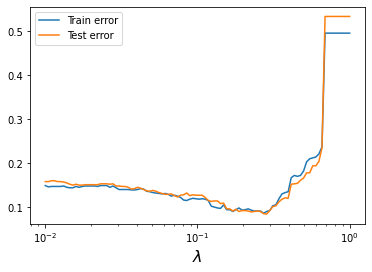

In [4]:
import matplotlib.pyplot as plt

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

## solving the problem with admm

$$ 
\textrm{minimize} \quad \frac{1}{2}\|w\|_2^2 + \lambda \sum h_j(w, b)
$$

Given an optimization term with N terms in the objective, it can be converted int a consensus form.

$$
\begin{equation}
\begin{aligned}
\textrm{minimize} \quad & \sum_{i=1}^N f_i(x_i) \\
\textrm{subject to} \quad & x_i = z\\
\end{aligned}
\end{equation}
$$

$z$ is a global variable that enforces consistency across the different workerse.

Implement a distributed SVM.

* https://web.stanford.edu/~boyd/papers/admm/svm/linear_svm.html
* https://www.cvxpy.org/examples/applications/consensus_opt.html?highlight=admm
* https://github.com/cvxpy/cvxpy/blob/master/examples/admm_svm_procs.py

In [ ]:
from multiprocessing import Process, Pipe

NUM_PROCS = 8
SPLIT_SIZE = X.shape[0]//NUM_PROCS
MAX_ITER = 10

data_splits = [
    (Y[i:i+SPLIT_SIZE].reshape(-1), X[i:i+SPLIT_SIZE]) 
    for i in range(0, X.shape[0], SPLIT_SIZE)
]

rho = 1.0
beta = cp.Variable(n)
v = cp.Variable()
lambd = cp.Parameter(nonneg=True)
f_list = []

# setting up the problem requires keeping in memory at least the size
# of the original data
for b, a in data_splits:
    loss = cp.sum(cp.pos(1 - cp.multiply(b, (a @ beta - v))))
    reg = cp.norm(beta, 1)
    # NOTE in the original formulation, there is no regularization parameter
    f_list.append(loss/m + lambd*reg)

def run_process(f, pipe):
    xbar = cp.Parameter(n, value=np.zeros(n))
    u = cp.Parameter(n, value=np.zeros(n))
    f += (rho/2)*cp.sum_squares(beta - xbar + u)
    prox = cp.Problem(cp.Minimize(f))
    # ADMM loop.
    while True:
        prox.solve()
        pipe.send(x.value)
        xbar.value = pipe.recv()
        u.value += x.value - xbar.value

```python
# Setup the workers.
pipes = []
procs = []
for i in range(NUM_PROCS):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_process, args=(f_list[i], remote))]
    procs[-1].start()

# ADMM loop.
for i in range(MAX_ITER):
    # Gather and average xi
    xbar = sum(pipe.recv() for pipe in pipes)/N
    # Scatter xbar
    for pipe in pipes:
        pipe.send(xbar)

[p.terminate() for p in procs]
```

And, well, multiprocessing stuff doesn't work in notebooks like usual.

## solving the problem with osqp

https://osqp.org/docs/examples/svm.html

This might be interesting if we can mix and match problems...